In [1]:
import sys
import time
import datetime
import os
import tensorflow as tf
import argparse
import json
import socket
from PIL import Image
from util import *
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from copy import deepcopy
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib.colors import hsv_to_rgb
from helpers import *

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logPath = "training/part2"
snapshotPath = "SNAPSHOTS/snapshots/"

In [3]:
with open("hyperParams.json") as f:
    instanceParams = json.load(f)

instanceParams

{u'baseLR': 1e-05,
 u'batchSize': 2,
 u'borderThicknessH': 0.02,
 u'borderThicknessW': 0.02,
 u'boundaryAlpha': 6.5,
 u'dataset': u'kitti2012',
 u'flowScale': 20.0,
 u'gradParams': {u'robustness': 0.46, u'scale': 255.0, u'weight': 6.408},
 u'instanceName': u'unsupFlownet',
 u'iterations': 500000,
 u'lossComponents': {u'asymmetricSmooth': True,
  u'backward': False,
  u'boundaries': False,
  u'gradient': False,
  u'smooth2nd': False},
 u'photoParams': {u'robustness': 1.0, u'scale': 255.0},
 u'printFreq': 1000,
 u'resnet': False,
 u'smooth2ndParams': {u'robustness': 0.21, u'scale': 1.0, u'weight': 0.53},
 u'smoothOccParams': {u'robustness': 0.9, u'scale': 1.8},
 u'smoothParams': {u'robustness': 1.0, u'scale': 1.0, u'weight': 4000},
 u'snapFreq': 5000,
 u'snapshotFreq': 20000,
 u'weightDecay': 0.0}

In [4]:
printFrequency = instanceParams["printFreq"]
batchSize = instanceParams["batchSize"]

iterations = instanceParams["iterations"]
baseLearningRate = instanceParams["baseLR"]
learningRate = baseLearningRate
snapshotFrequency = instanceParams["snapshotFreq"]

from dotmap import DotMap
arg = DotMap()
arg.logDev = False
arg.resume = 'n'
resume, startIteration, snapshotFiles = checkResume(snapshotPath,logPath, arg)

resuming from iteration 501000


### Training

In [ ]:
with tf.device("/gpu:0"):
    trainingData = TrainingData(batchSize,instanceParams)

with tf.device("/gpu:0"):
    # init
    with tf.variable_scope("netShare"):
        networkBodyF = NetworkBody(trainingData,instanceParams)
    with tf.variable_scope("netShare",reuse=True):
        networkBodyB = NetworkBody(trainingData,instanceParams,flipInput=True)

    trainingLoss = TrainingLoss(instanceParams,networkBodyF,networkBodyB,trainingData)
    solver,learningRateTensor = attachSolver(trainingLoss.loss)

    # loss scheduling
    recLossBWeightTensor = trainingLoss.recLossBWeight

Reading Tensor("ImagePairData/image_data_reader/Placeholder:0", dtype=string, device=/device:GPU:0)
Reading Tensor("ImagePairData/image_data_reader_1/Placeholder:0", dtype=string, device=/device:GPU:0)
Reading Tensor("ImagePairData/image_data_reader_2/Placeholder:0", dtype=string, device=/device:GPU:0)
Reading Tensor("ImagePairData/image_data_reader_3/Placeholder:0", dtype=string, device=/device:GPU:0)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
INFO:tensorflow:Summary name Network Outut Smoothness is illegal; using Network_Outut_Smoothness instead.
> /home/y788zhang/joint_seg_flow/src/util/lossComponents/smoothLoss.py(75)make_gt_masks()
-> j = i + 1
(Pdb) gt_mask.shape
TensorShape([Dimension(2), Dimension(480), Dimension(854), Dimension(2)])


In [6]:
# merge summaries
merged = tf.summary.merge_all()
# saver
saver = tf.train.Saver(max_to_keep=0)

In [7]:
printFrequency = 100
snapshotFrequency = 1000
iterations = 100000
startIteration = 501000
print(printFrequency)
print(snapshotFrequency)
print(iterations)
print(startIteration)

100
1000
100000
501000


In [8]:
# start
with sessionSetup(arg) as sess:
    if resume:
        saver.restore(sess,snapshotPath+snapshotFiles[-1][:-6])
    else:
        saver.restore(sess,
                      '../model_download_scripts/photometric_smoothness/weights/iter_0000000000500000.ckpt')

    trainingData.dataQueuer.start_queueing(sess)

    #start summary writer
    summary_writer = tf.summary.FileWriter(logPath, sess.graph)

    #run
    lastPrint = time.time()
    for i in range(startIteration, startIteration + iterations + 10):
        # scheduled values
        learningRate = learningRateSchedule(baseLearningRate, i)
        recLossBWeight = unsupLossBSchedule(i)

         #run training
        feed_dict = {
            learningRateTensor: learningRate,
            recLossBWeightTensor: recLossBWeight,
        }
        summary,result,totalLoss = sess.run([merged,solver,trainingLoss.loss], feed_dict=feed_dict)

        if (i+1) % printFrequency == 0:
            timeDiff = time.time() - lastPrint
            itPerSec = printFrequency/timeDiff
            remainingIt = startIteration + iterations + 10 - i
            eta = remainingIt/itPerSec
            print("Iteration "+str(i+1)+": loss: "+str(totalLoss)+", iterations per second: "+str(itPerSec)+", ETA: "+str(datetime.timedelta(seconds=eta)))+", lr: "+str(learningRate)

            summary_writer.add_summary(summary,i+1)
            summary_writer.flush()
            lastPrint = time.time()

        if (i+1) % snapshotFrequency == 0:
            saver.save(sess,"snapshots/iter_"+str(i+1).zfill(16)+".ckpt")

        sys.stdout.flush()

    #close queing
    trainingData.dataQueuer.close(sess)

INFO:tensorflow:Restoring parameters from snapshots/iter_0000000000501000.ckpt
Iteration 501100: loss: [[1.0225718]
 [1.0225718]], iterations per second: 1.01173017316, ETA: 1 day, 3:25:52.614729, lr: 2.5e-06


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "util/data_input/DataQueuer.py", line 88, in thread_main
    exit()
NameError: global name 'exit' is not defined
Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading.py", line 754, in run
    self.__target(*self.__args, **self.__kwargs)
  File "util/data_input/DataQueuer.py", line 88, in thread_main
    exit()
NameError: global name 'exit' is not defined

Exception in thread Thread-8:
Traceback (most recent call last):
  File "/home/y788zhang/.conda/envs/p27/lib/python2.7/threading.

KeyboardInterrupt: 

### Testing

In [5]:
datasetRoot = '../example_data/'
frame0Path = '../example_data/datalists/swing_11_im0.txt'
frame1Path = '../example_data/datalists/swing_11_im1.txt'
gt0Path = '../example_data/datalists/swing_11_gt0.txt'
desiredHeight = 480
desiredWidth = 854

In [6]:
with open(frame0Path) as f:
    imagePairs0 = [datasetRoot+x[:-1] for x in f.readlines()]
with open(frame1Path) as f:
    imagePairs1 = [datasetRoot+x[:-1] for x in f.readlines()]
with open(gt0Path) as f:
    gtPairs1 = [datasetRoot+x[:-1] for x in f.readlines()]

In [7]:
testData = TestData(imagePairs0,imagePairs1,gtPairs1,1,desiredHeight,desiredWidth)

In [8]:
with tf.device("/gpu:0"):
    with tf.variable_scope("netShare"):
        networkBody = NetworkBody(testData,instanceParams)
    flowFinal = networkBody.flows[0]
    gt = testData.frame0["gt"]
    sLoss = asymmetricSmoothLoss(flowFinal, gt, instanceParams, 1, 1, None, instanceParams["boundaryAlpha"], True)
    sGrad = tf.gradients(sLoss, flowFinal)[0]

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
flowViz = flowToRgb(flowFinal)
transformGrid = flowTransformGrid(flowFinal)
mean = tf.expand_dims(tf.expand_dims(tf.expand_dims([0.407871, 0.457525, 0.481094], 0), 0), 0)

In [10]:
saver = tf.train.Saver()

# config tensorflow
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True

In [11]:
test_length = 70
start = 0
result_dir = 'results'
iterations = 515000

flows = []
viz = []
gradients = []
ground_truths = []
arrs = []
with tf.Session(config=config) as sess:
    saver.restore(sess,"snapshots_frame43/iter_"+str(iterations).zfill(16)+".ckpt")

    # run
    lastPrint = time.time()
    for i in range(start, start + min(test_length, len(imagePairs0))):
        feed_dict = {
            testData.im0File: imagePairs0[i],
            testData.im1File: imagePairs1[i],
            testData.gt0File: gtPairs1[i]
        }
        hsv, f, g, t = sess.run([flowViz, flowFinal, sGrad, gt],feed_dict=feed_dict)

        gradients.append(deepcopy(g))
        ground_truths.append(deepcopy(t))
        flows.append(deepcopy(f))
        h, w = 480, 854
        arr = np.maximum(np.minimum(np.asarray(hsv),1), 0)
        arr = np.squeeze(np.asarray(arr*255,np.uint8))
        arrs.append(deepcopy(arr[:h,:w,:]))
        im = Image.fromarray(arr[:h,:w,:])
        viz.append(deepcopy(im))
        # im.save("{}/{}.png".format(result_dir, str(i).zfill(3)))

INFO:tensorflow:Restoring parameters from snapshots_frame43/iter_0000000000515000.ckpt


In [12]:
flows = np.array(flows)
gradients = np.array(gradients)
arrs = np.array(arrs)
ground_truths = np.array(ground_truths)

flows = np.squeeze(flows, axis=1)
gradients = np.squeeze(gradients, axis=1)
ground_truths = np.squeeze(ground_truths, axis=1)

<IPython.core.display.Javascript object>


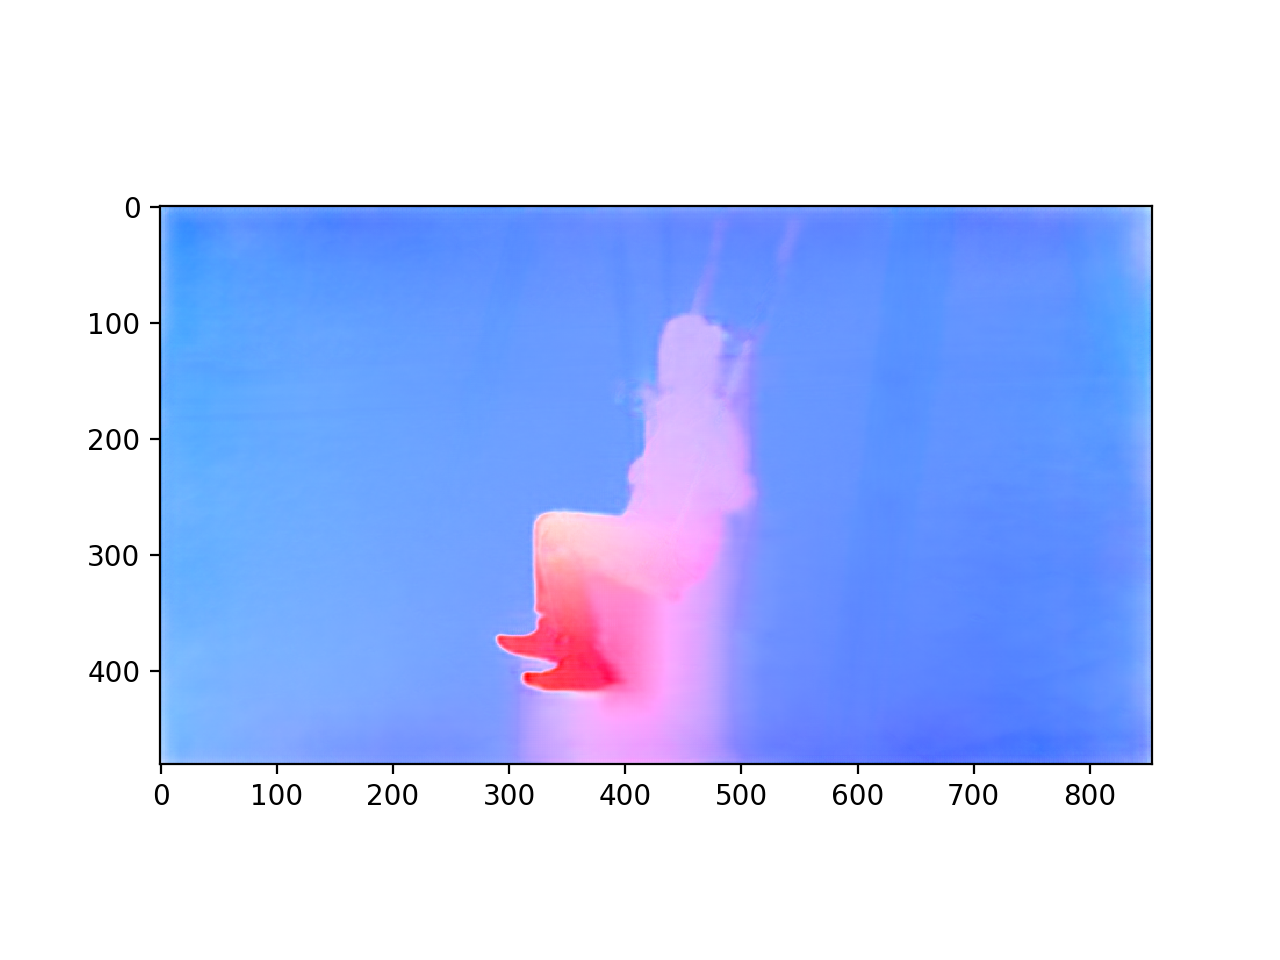

In [13]:
plt.imshow(arrs[0])

In [14]:
np.save("flow1", flows)

In [ ]:
np.abs(4.2757964 - 4.580006)

In [ ]:
# np.save("./NPY/flow_w1_g25", flows)
# np.save("./NPY/gradient_w1_g25", gradients)
# np.save("./NPY/arrs_w1", arrs)
# np.save("./NPY/gt", ground_truths)

In [ ]:
def plot_smooth_grad(i, overlay=True, sparsity=32):
    # optical flow hsv
    # plt.figure(figsize=(15,9))
    plt.imshow(viz[i])

    # segmentation mask
    if overlay:
        plt.imshow(np.reshape(ground_truths[i], (480, 854)), cmap='gray', alpha=0.1)

    # optical flow vector field
    X, Y = np.mgrid[0:854, 0:480]
    est = flows[i]
    est = np.transpose(est, (1, 0, 2))
    U, V = est[:,:,0], est[:,:,1]
    plt.quiver(X[::sparsity, ::sparsity],
               Y[::sparsity, ::sparsity],
               U[::sparsity, ::sparsity],
               V[::sparsity, ::sparsity],
               color='black',
               edgecolor='k', alpha=0.8,angles='xy',scale_units='xy', scale=1)

    # gradient vector field
    sgrad = -np.transpose(gradients[0], (1, 0, 2))
    U, V = sgrad[:,:,0], sgrad[:,:,1]
    plt.quiver(X[::sparsity, ::sparsity],
               Y[::sparsity, ::sparsity],
               U[::sparsity, ::sparsity],
               V[::sparsity, ::sparsity],
               color='yellow',
               edgecolor='k', alpha=0.8,angles='xy',scale_units='xy', scale=300)
    plt.axis('off')
    plt.show()

In [ ]:
plot_smooth_grad(11, True, sparsity=10)